In [2]:
cd d:\\DataScience\\AnomalyDetection_JPMC

d:\DataScience\AnomalyDetection_JPMC


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer, f1_score, recall_score, confusion_matrix, classification_report

from sklearn.ensemble import IsolationForest

from sklearn import set_config
set_config(display='diagram')

%matplotlib inline
pd.set_option('display.max_column',None)

In [4]:
filepath = Path("data/original/training_data.csv")

df = pd.read_csv(filepath)
df.shape

(1348359, 13)

In [5]:
df.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2051-12-30 14:37:07,MOVE-FUNDS-2003248,COMPANY-2003012,ACCOUNT-2003019,GERMANY,59.0,CCB,JPMC-CLIENT-2003007,ACCOUNT-2003030,LIBERIA,2000.27,0,MOVE-FUNDS
1,2030-04-23 11:24:51,PAYMENT-550486,JPMC-CLIENT-550438,ACCOUNT-550452,USA,21626.0,CCB,BILL-COMPANY-550487,ACCOUNT-550488,BHUTAN,84.93,0,MAKE-PAYMENT
2,2039-01-04 05:15:45,PAYMENT-1127038,JPMC-CLIENT-1126759,ACCOUNT-1126774,USA,27531.0,CCB,BILL-COMPANY-1127039,ACCOUNT-1127040,USA,13.81,0,MAKE-PAYMENT
3,2048-10-26 14:56:47,CASH-CHECK-1780299,JPMC-CLIENT-1780040,ACCOUNT-1780070,IRAQ,7541.0,CCB,NaN,NaN,NaN,797.53,0,EXCHANGE
4,2034-09-09 12:25:18,EXCHANGE-837930,JPMC-CLIENT-837717,ACCOUNT-837727,USA,12315.0,CCB,NaN,NaN,NaN,225.52,0,WITHDRAWAL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348359 entries, 0 to 1348358
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1348359 non-null  object 
 1   Transaction_Id    1348359 non-null  object 
 2   Sender_Id         1151056 non-null  object 
 3   Sender_Account    1151056 non-null  object 
 4   Sender_Country    1151056 non-null  object 
 5   Sender_Sector     1151056 non-null  float64
 6   Sender_lob        1151056 non-null  object 
 7   Bene_Id           1154089 non-null  object 
 8   Bene_Account      1154089 non-null  object 
 9   Bene_Country      1154089 non-null  object 
 10  USD_amount        1348359 non-null  float64
 11  Label             1348359 non-null  int64  
 12  Transaction_Type  1348359 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 133.7+ MB


In [7]:
df.isnull().sum()

Time_step                0
Transaction_Id           0
Sender_Id           197303
Sender_Account      197303
Sender_Country      197303
Sender_Sector       197303
Sender_lob          197303
Bene_Id             194270
Bene_Account        194270
Bene_Country        194270
USD_amount               0
Label                    0
Transaction_Type         0
dtype: int64

In [8]:
is_fraud = df[df['Label']==1]

Text(0, 0.5, 'Count')

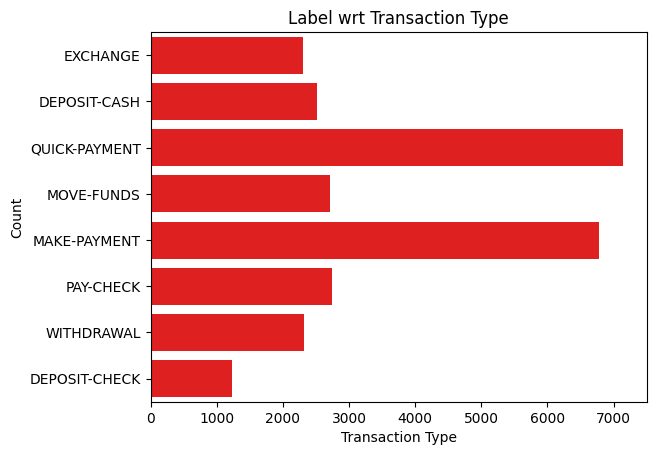

In [9]:
sns.countplot(data=is_fraud, y='Transaction_Type', color='red')
plt.title('Label wrt Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')

In [10]:
df.Transaction_Type.value_counts()

MAKE-PAYMENT     502016
QUICK-PAYMENT    195562
MOVE-FUNDS       162164
DEPOSIT-CHECK     98745
DEPOSIT-CASH      98558
EXCHANGE          97456
PAY-CHECK         97044
WITHDRAWAL        96814
Name: Transaction_Type, dtype: int64

We have noticed there are some null values. But these null values are not because the data is missing due to some error or data entry, rather there is no data present for such scenarios.<br>
For example:<br>
- Cases where reciever info should be missing:
    - WITHDRAWL
    - EXCHANGE
- Cases where sender info should be missing:
    - DEPOSIT-CASH
    - DEPOSIT-CHECK
- Cases where nothing should be be missing:
    - PAY-CHECK
    - MOVE-FUNDS
    - QUICK-PAYMENT
    - MAKE-PAYMENT

We will only cater few of the transactions type.

In [11]:
df = df[df.Transaction_Type.isin(['PAY-CHECK', 'MOVE-FUNDS', 'QUICK-PAYMENT', 'MAKE-PAYMENT'])]

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(train.shape, test.shape)

(765428, 13) (191358, 13)


In [13]:
train['Label'].value_counts()

0    749940
1     15488
Name: Label, dtype: int64

In [14]:
test['Label'].value_counts()

0    187467
1      3891
Name: Label, dtype: int64

In [15]:
for each in train.select_dtypes(include=['object']).columns:
    print(f"{train[each].nunique()} uniques in {each} column.")

453703 uniques in Time_step column.
765428 uniques in Transaction_Id column.
50345 uniques in Sender_Id column.
65796 uniques in Sender_Account column.
252 uniques in Sender_Country column.
1 uniques in Sender_lob column.
235089 uniques in Bene_Id column.
250074 uniques in Bene_Account column.
252 uniques in Bene_Country column.
4 uniques in Transaction_Type column.


### Feature Engineering

Steps:<br>
1. Extract time features and convert them in cyclic notations.
2. Create new columns with interaction count and interaction amount mean.
3. Apply cube root to amount and amount mean.
4. Target encode the categorical variables.
5. Drop columns that are not needed.
6. One hot encode and scale.

In [16]:
class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
        
        if self.columns is None:
            return X
        else:
            X_ = X.copy()
            for each in self.columns:
                X_[each] = pd.to_datetime(X[each])
                day = X_[each].dt.day
                hour = X_[each].dt.hour
                day_of_week = X_[each].dt.dayofweek
                X_['DaySin'] = np.sin(2 * np.pi * day / 31)
                X_['DayCos'] = np.cos(2 * np.pi * day / 31)
                X_['HourSin'] = np.sin(2 * np.pi * hour / 24)
                X_['HourCos'] = np.cos(2 * np.pi * hour / 24)
                X_['DoWSin'] = np.sin(2 * np.pi * day_of_week / 7)
                X_['DoWCos'] = np.cos(2 * np.pi * day_of_week / 7)
            return X_

In [17]:
class InteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.grouping_columns = ['Sender_Id', 'Bene_Id']

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")

        self.interaction_frequency = X.groupby(self.grouping_columns).size().reset_index().rename(columns={0: 'Interaction_Frequency'})
        self.interaction_amount = X.groupby(self.grouping_columns)['USD_amount'].mean().reset_index().rename(columns = {'USD_amount':'Amount_Mean'})
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
            
        X_ = X.copy()
        X_ = pd.merge(X_, self.interaction_frequency, on=self.grouping_columns, how='left')
        X_['Interaction_Frequency'] = X_['Interaction_Frequency'].fillna(0)
        X_ = pd.merge(X_, self.interaction_amount, on=self.grouping_columns, how='left')
        X_['Amount_Mean'] = X_['Amount_Mean'].fillna(X_['Amount_Mean'].mean())
        return X_

In [18]:
class CubeRootTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
            
        if self.columns is None:
            return X
        else:
            X_ = X.copy()
            X_[self.columns] = X_[self.columns].apply(lambda x: np.cbrt(x))
            return X_

In [19]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mapping = {}
        self.target = 'Label'
    
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")
        
        y.name = self.target
        X_ = pd.concat([X,y], axis=1)
        for col in self.columns:
            encoding_map = X_.groupby(col)[self.target].mean().to_dict()
            self.mapping[col] = encoding_map
        return self
        
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(f"{X} must be a pandas DataFrame")

        X_ = X.copy()
        for col in self.columns:
            X_[col] = X_[col].map(self.mapping[col])
            X_[col] = X_[col].fillna(np.array(list(self.mapping[col].values())).mean())
        return X_

In [20]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, dropping_columns):
        self.dropping_columns = dropping_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        return X_.drop(self.dropping_columns, axis=1)

In [21]:
dropping_columns = ['Transaction_Id', 'Time_step', 'Sender_lob']
timestamp_columns = ['Time_step']
target_encoding_columns = ['Sender_Id', 'Sender_Account', 'Sender_Country', 'Bene_Id', 'Bene_Account', 'Bene_Country']
cube_root = ['USD_amount', 'Amount_Mean']

In [22]:
numerical_columns = ['Sender_Id', 'Sender_Account', 'Sender_Country', 'Sender_Sector',
       'Bene_Id', 'Bene_Account', 'Bene_Country', 'USD_amount', 'DaySin', 'DayCos', 'HourSin', 'HourCos', 'DoWSin',
       'DoWCos', 'Interaction_Frequency', 'Amount_Mean']

categorical_columns = ['Transaction_Type']

In [23]:
feature_extraction_pipeline = Pipeline(
    steps = [
        ('target_encoder', TargetEncoder(target_encoding_columns)),
        ('time_extractor', TimestampTransformer(timestamp_columns)),
        ('interaction', InteractionTransformer()),
        ('cube_root', CubeRootTransformer(cube_root)),
        ('column_dropper', ColumnDropper(dropping_columns))
    ]
)

In [24]:
# assert all(feature_extraction_pipeline.fit_transform(train).columns == ['Sender_Id', 'Sender_Account', 'Sender_Country', 'Sender_Sector',
#        'Bene_Id', 'Bene_Account', 'Bene_Country', 'USD_amount', 'Label',
#        'Transaction_Type', 'DaySin', 'DayCos', 'HourSin', 'HourCos', 'DoWSin',
#        'DoWCos', 'Interaction_Frequency', 'Amount_Mean'])

In [25]:
preprocessor = ColumnTransformer(
    [
        ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ],
    remainder = 'passthrough'
)

In [26]:
X_train = train.drop('Label', axis=1)
y_train = train['Label']

X_test = test.drop('Label', axis=1)
y_test = test['Label']

### Modelling

In [27]:
model_pipeline = Pipeline(
    steps = [
        ('feature_extraction', feature_extraction_pipeline),
        ('pre_process', preprocessor),
        ('isolation_forest', IsolationForest(contamination=0.25))
    ]
)

In [28]:
# def custom_recall(clf, X, y_true):
#     anomaly_score = clf.predict(X)
#     y_pred = np.where(anomaly_score==1, 0, 1)
#     recall = recall_score(y_true, y_pred)
#     return recall

In [29]:
# params = {
#     'isolation_forest__n_estimators': list(range(100, 800, 100)), 
#     'isolation_forest__contamination': list(np.linspace(0.1, 0.4, 7))
# }

In [30]:
# grid = RandomizedSearchCV(model_pipeline, params, cv=3, scoring=custom_recall, verbose=10)
# grid.fit(X_train, y_train)

In [31]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_extraction',
                 Pipeline(steps=[('target_encoder',
                                  TargetEncoder(columns=['Sender_Id',
                                                         'Sender_Account',
                                                         'Sender_Country',
                                                         'Bene_Id',
                                                         'Bene_Account',
                                                         'Bene_Country'])),
                                 ('time_extractor',
                                  TimestampTransformer(columns=['Time_step'])),
                                 ('interaction', InteractionTransformer()),
                                 ('cube_root',
                                  CubeRootTransformer(columns=['USD_amount',
                                                               'Amount...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Transaction_Type']),
                                                 ('scaler', StandardScaler(),
                                                  ['Sender_Id',
                                                   'Sender_Account',
                                                   'Sender_Country',
                                                   'Sender_Sector', 'Bene_Id',
                                                   'Bene_Account',
                                                   'Bene_Country', 'USD_amount',
                                                   'DaySin', 'DayCos',
                                                   'HourSin', 'HourCos',
                                                   'DoWSin', 'DoWCos',
                                                   'Interaction_Frequency',
                                                   'Amount_Mean'])])),
                ('isolation_forest', IsolationForest(contamination=0.25))])

In [32]:
anomaly_score = model_pipeline.predict(X_test)
y_pred = np.where(anomaly_score==1, 0, 1)

In [33]:
confusion_matrix(y_test, y_pred)

array([[142775,  44692],
       [  1891,   2000]], dtype=int64)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    187467
           1       0.04      0.51      0.08      3891

    accuracy                           0.76    191358
   macro avg       0.51      0.64      0.47    191358
weighted avg       0.97      0.76      0.84    191358



In [35]:
import pickle
pickle.dump(model_pipeline, open('artifacts/model_pipeline.pkl','wb'))